# VAE Analysis - Faces dataset

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

/home/comadan/.venv/gdl/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## data

In [8]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [9]:
att.head()

,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## architecture

In [10]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

## reconstructing faces

Found 143422 validated image filenames.


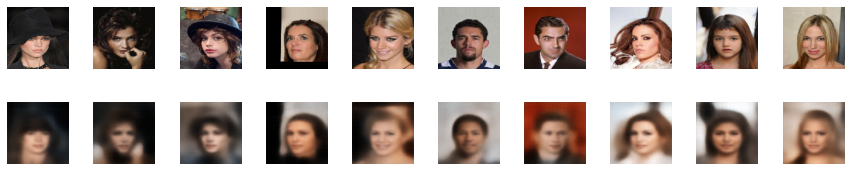

In [11]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

20/20 [==============================] - 0s 12ms/step


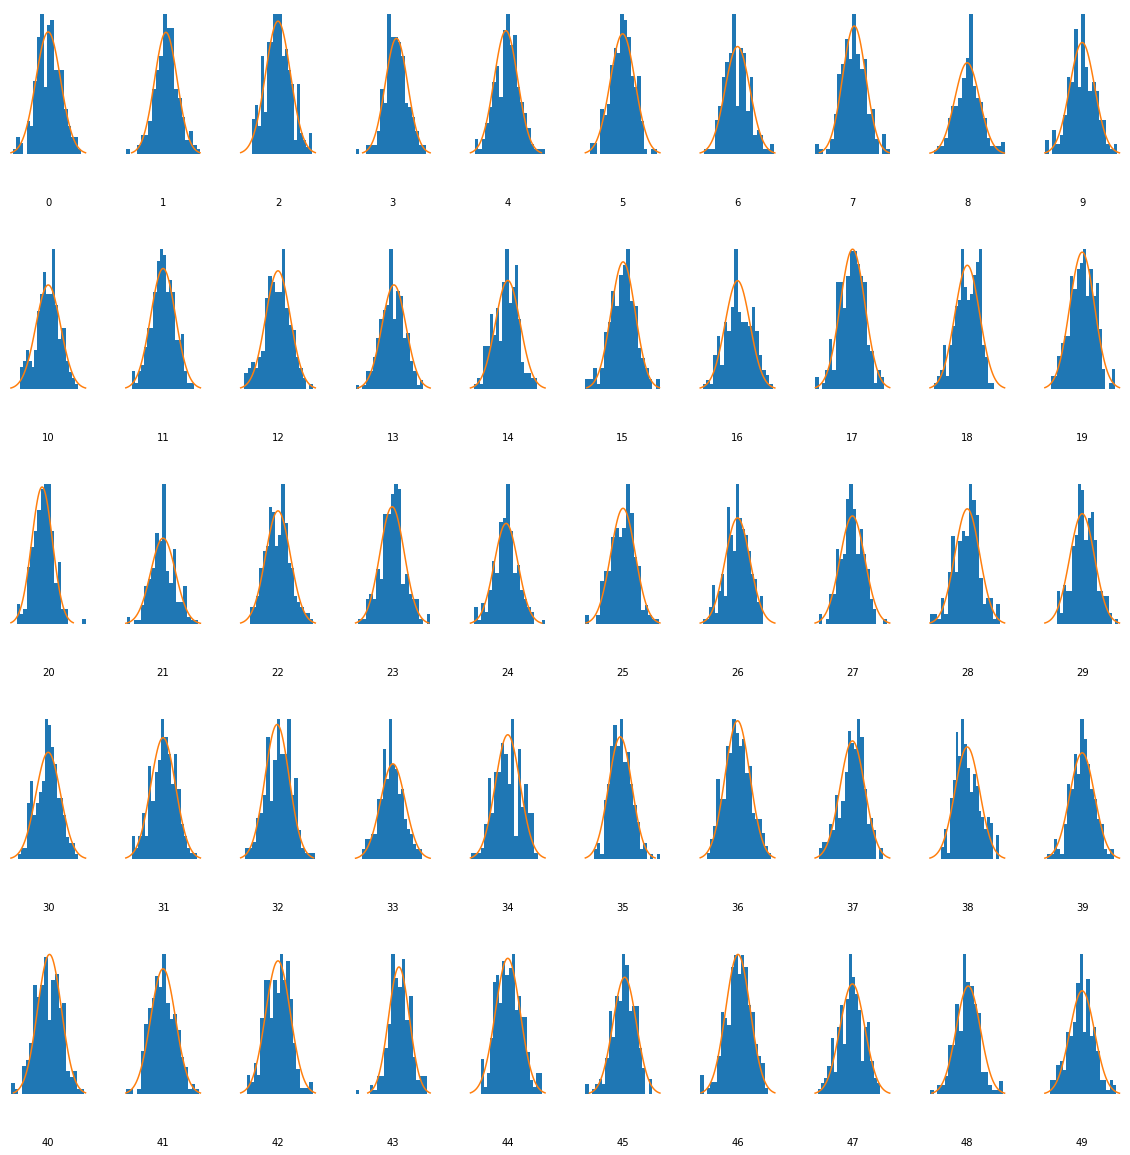

In [12]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

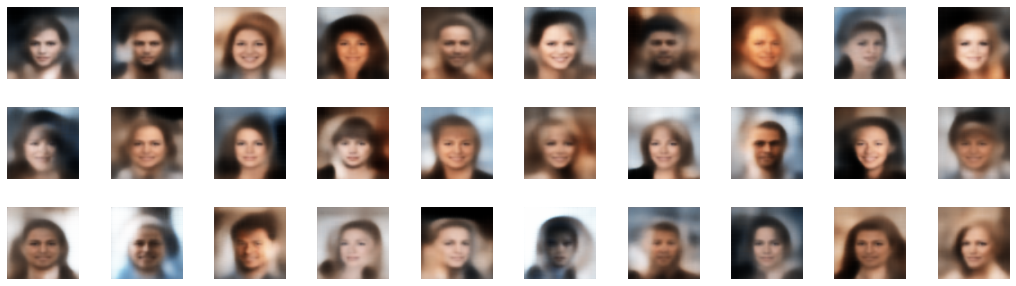

In [13]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [14]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [15]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [16]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 143422 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
245    : 1.053    : 1.059    : 1.617    : 1.617
501    : 0.659    : 0.686    : 1.285    : -0.331
761    : 0.364    : 0.354    : 1.227    : -0.058
1026    : 0.234    : 0.253    : 1.174    : -0.053
1319    : 0.209    : 0.188    : 1.156    : -0.018
1574    : 0.167    : 0.174    : 1.109    : -0.047
1819    : 0.136    : 0.162    : 1.081    : -0.027
2091    : 0.124    : 0.113    : 1.061    : -0.02
2331    : 0.099    : 0.106    : 1.047    : -0.015
2582    : 0.081    : 0.103    : 1.047    : -0.0
2834    : 0.085    : 0.086    : 1.037    : -0.01
3106    : 0.083    : 0.072    : 1.034    : -0.003
3363    : 0.067    : 0.073    : 1.03    : -0.004
3636    : 0.064    : 0.064    : 1.033    : 0.003
3877    : 0.057    : 0.057    : 1.043    : 0.01
4128    : 0.052    : 0.062    : 1.03    : -0.013
4396    : 0.054    : 0.053    : 1.023    : -0.007
4658    : 0.048    : 0.051    : 1.016    : -0.007
492

In [17]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 143422 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
26    : 3.582    : 0.662    : 3.679    : 3.679
59    : 2.29    : 0.44    : 2.624    : -1.055
92    : 1.061    : 0.256    : 2.199    : -0.425
124    : 0.772    : 0.185    : 2.014    : -0.184
158    : 0.603    : 0.138    : 1.88    : -0.135
195    : 0.485    : 0.127    : 1.797    : -0.083
229    : 0.362    : 0.102    : 1.796    : -0.001
260    : 0.313    : 0.084    : 1.755    : -0.041
292    : 0.299    : 0.074    : 1.696    : -0.059
331    : 0.278    : 0.07    : 1.692    : -0.004
369    : 0.247    : 0.061    : 1.679    : -0.012
401    : 0.213    : 0.055    : 1.669    : -0.01
434    : 0.191    : 0.058    : 1.67    : 0.001
465    : 0.181    : 0.048    : 1.657    : -0.013
499    : 0.178    : 0.044    : 1.656    : -0.001
523    : 0.14    : 0.044    : 1.647    : -0.01
552    : 0.148    : 0.041    : 1.673    : 0.027
573    : 0.113    : 0.036    : 1.666    : -0.007
604    : 0.14    : 0.0

In [18]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 143422 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
66    : 2.045    : 0.778    : 2.319    : 2.319
144    : 1.305    : 0.499    : 1.93    : -0.389
219    : 0.685    : 0.271    : 1.825    : -0.105
295    : 0.431    : 0.22    : 1.777    : -0.049
364    : 0.345    : 0.163    : 1.705    : -0.072
429    : 0.283    : 0.136    : 1.685    : -0.02
497    : 0.215    : 0.11    : 1.661    : -0.023
564    : 0.216    : 0.09    : 1.654    : -0.007
644    : 0.187    : 0.078    : 1.648    : -0.006
706    : 0.166    : 0.072    : 1.634    : -0.014
783    : 0.17    : 0.065    : 1.625    : -0.008
852    : 0.143    : 0.057    : 1.615    : -0.011
901    : 0.109    : 0.053    : 1.607    : -0.007
974    : 0.124    : 0.048    : 1.59    : -0.018
1056    : 0.125    : 0.046    : 1.588    : -0.001
1122    : 0.098    : 0.041    : 1.584    : -0.004
1210    : 0.103    : 0.04    : 1.584    : -0.0
1287    : 0.093    : 0.039    : 1.585    : 0.001
1362    : 0.092  

Eyeglasses Vector


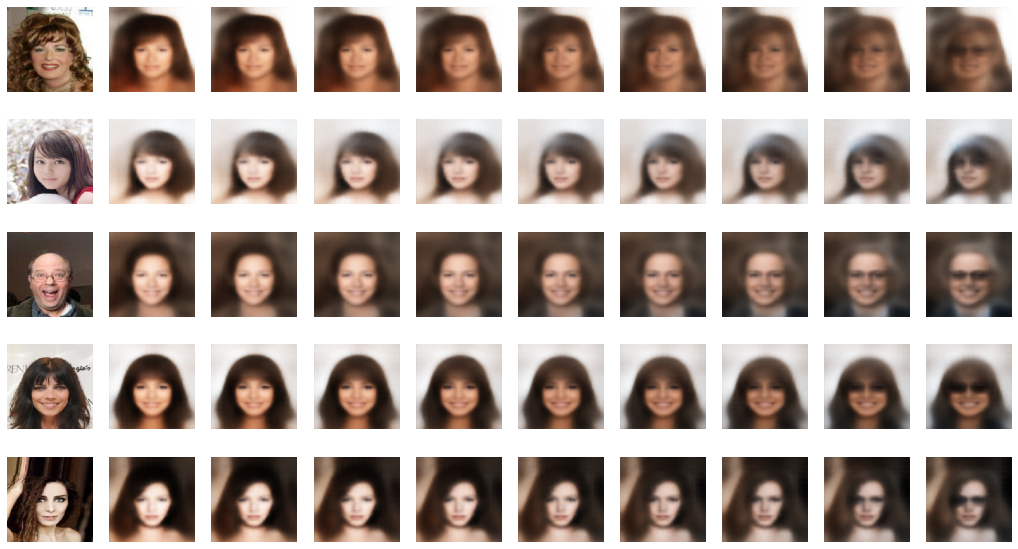

In [19]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [20]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


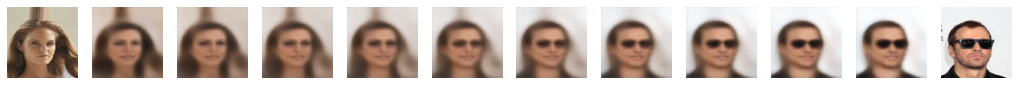

In [21]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


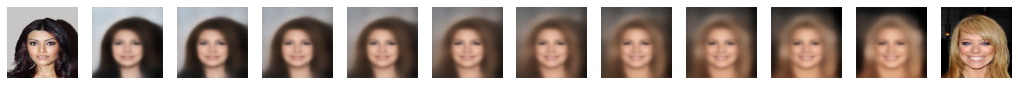

In [22]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


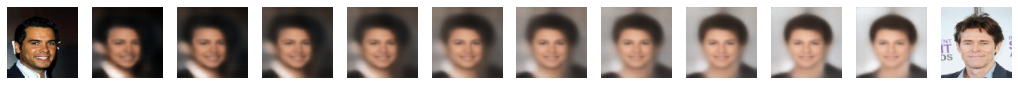

In [23]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)